In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pickle
from scipy import fftpack

In [2]:
# functionality for smoothing square, monochrome images
# using 2D FFTs

def smooth_one_image(img, alpha, mode='gaussian'):
    assert len(img.shape) == 2
    assert img.shape[0] == img.shape[1]
    assert img.max() <= 1.0
    size = img.shape[0]
    img_fft = fftpack.fft2(img)
    lowpass_fft = make_lowpass_fft(alpha, size, mode)
    img_fft_lowpass = img_fft * lowpass_fft
    img_lowpass = fftpack.ifft2(img_fft_lowpass)
    assert np.allclose(np.imag(img_lowpass), 0.0, atol=1e-1)
    return np.real(img_lowpass)


def smooth_images(imgs, alpha, mode='gaussian'):
    size = imgs.shape[1]
    X = imgs.reshape([-1, size ** 2])
    smoothed = np.apply_along_axis(
        lambda img: smooth_one_image(img.reshape([size, size]), alpha, mode),
        1,
        X
    )
    return smoothed.reshape([-1, size, size])


def make_lowpass_fft(alpha, size, mode):
    assert mode in ('gaussian', 'circle')
    f = {'gaussian': discrete_2d_gaussian,
         'circle': discrete_2d_circle
        }[mode]
    circular = np.fromfunction(
        f(alpha, size), (size, size)
    )
    return fftpack.ifftshift(circular)


def discrete_2d_circle(alpha, size):
    midpoint = (size - 1.0) / 2.0
    def _discrete_circle(i, j):
        dist_sq = (i - midpoint) ** 2 + (j - midpoint) ** 2
        max_dist_sq = alpha ** 2 * size ** 2
        return np.where(max_dist_sq <= dist_sq,
                        np.zeros((size, size)),
                        np.ones((size, size)))
    return _discrete_circle


def discrete_2d_gaussian(alpha, size):
    midpoint = (size - 1.0) / 2.0
    def _discrete_2d_gaussian(i, j):
        dist_sq = (i - midpoint) ** 2 + (j - midpoint) ** 2
        return np.exp(-0.5
                      * dist_sq
                      / size ** 2
                      / alpha)
    return _discrete_2d_gaussian

In [3]:
# downloaded and pickled using
# https://github.com/hsjeong5/MNIST-for-Numpy

with open("../data/mnist.pkl",'rb') as f:
    mnist = pickle.load(f)

X_train, Y_train, X_test, Y_test = (
    mnist["training_images"],
    mnist["training_labels"],
    mnist["test_images"],
    mnist["test_labels"]
)

X_train = np.reshape(X_train, [-1, 28, 28]) / 255.0
X_test = np.reshape(X_test, [-1, 28, 28]) / 255.0

In [4]:
alpha = 0.01

X_train_smoothed = smooth_images(X_train, alpha)
X_test_smoothed = smooth_images(X_test, alpha)

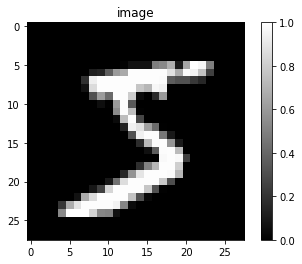

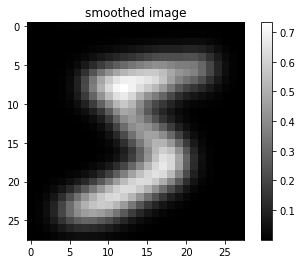

In [5]:
img = X_train[0]
smoothed_img = X_train_smoothed[0]

plt.figure()
plt.title('image')
plt.imshow(img, plt.cm.gray)
plt.colorbar()
plt.show()

plt.figure()
plt.title('smoothed image')
plt.imshow(smoothed_img, plt.cm.gray)
plt.colorbar()
plt.show()

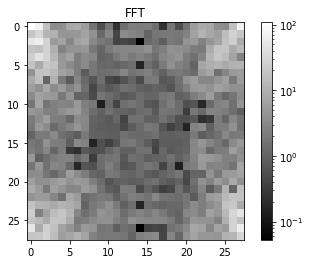

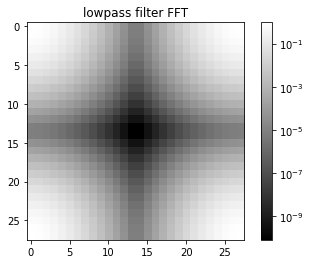

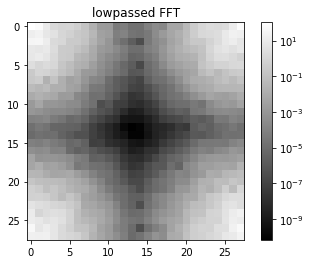

In [6]:
# taking a look at the Fourier representations

img_fft = fftpack.fft2(img)
lowpass_fft = make_lowpass_fft(alpha, 28, 'gaussian')

plt.figure()
plt.title('FFT')
plt.imshow(np.abs(img_fft), plt.cm.gray, norm=LogNorm())
plt.colorbar()
plt.show()

plt.figure()
plt.title('lowpass filter FFT')
plt.imshow(np.abs(lowpass_fft), plt.cm.gray, norm=LogNorm())
plt.colorbar()
plt.show()

plt.figure()
plt.title('lowpassed FFT')
plt.imshow(np.abs(lowpass_fft * img_fft), plt.cm.gray, norm=LogNorm())
plt.colorbar()
plt.show()